# Requirements

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

import ast

# ► Entrega I — Análisis Exploratorio



# 📝 Análisis exploratorio de sentimientos y rendimiento en trailers de películas


## 📌 __Carga del dataset__
---

*   El archivo `movies_youtube_sentiments.csv` lo subí desde githhub.

In [ ]:
# Data desde el repo en GitHub-raw-
url = "https://raw.githubusercontent.com/JotaNota/YoutubeTrailer_ML/Data_Exploration_I/data/raw/movies_youtube_sentiments.csv"
df = pd.read_csv(url)

In [ ]:
# Leer y explorar las primeras filas del dataset
df.head(3)

,name,trailer_link,video_id,sentiment_scores,favorability,rating,genre,year,released,votes,director,writer,star,country,budget,gross,company,runtime
0,Harry Potter and the Goblet of Fire,https://www.youtube.com/watch?v=3EGojp4Hh6I,3EGojp4Hh6I,"{'positive': 87, 'neutral': 112, 'negative': 51}",0.630435,PG-13,Adventure,2005,"November 18, 2005 (United States)",566000.0,Mike Newell,Steve Kloves,Daniel Radcliffe,United Kingdom,150000000.0,896678241.0,Warner Bros.,157.0
1,The 40-Year-Old Virgin,https://www.youtube.com/watch?v=YnDeJn-BX5Q,YnDeJn-BX5Q,"{'positive': 40, 'neutral': 45, 'negative': 18}",0.689655,R,Comedy,2005,"August 19, 2005 (United States)",407000.0,Judd Apatow,Judd Apatow,Steve Carell,United States,26000000.0,177378645.0,Universal Pictures,116.0
2,Memoirs of a Geisha,https://www.youtube.com/watch?v=4L-xlmakQvc,4L-xlmakQvc,"{'positive': 120, 'neutral': 89, 'negative': 41}",0.745342,PG-13,Drama,2005,"December 23, 2005 (United States)",141000.0,Rob Marshall,Robin Swicord,Ziyi Zhang,France,85000000.0,162242962.0,Columbia Pictures,145.0


In [ ]:
# Revisar estructura general y nombres de columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1105 entries, 0 to 1104
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1105 non-null   object 
 1   trailer_link      1105 non-null   object 
 2   video_id          1105 non-null   object 
 3   sentiment_scores  1105 non-null   object 
 4   favorability      1105 non-null   float64
 5   rating            1104 non-null   object 
 6   genre             1105 non-null   object 
 7   year              1105 non-null   int64  
 8   released          1105 non-null   object 
 9   votes             1105 non-null   float64
 10  director          1105 non-null   object 
 11  writer            1104 non-null   object 
 12  star              1105 non-null   object 
 13  country           1105 non-null   object 
 14  budget            901 non-null    float64
 15  gross             1105 non-null   float64
 16  company           1105 non-null   object 


In [ ]:
print(*df.columns, sep="\n")

name
trailer_link
video_id
sentiment_scores
favorability
rating
genre
year
released
votes
director
writer
star
country
budget
gross
company
runtime


In [ ]:
# Eliminar columnas que no son útiles para el análisis
df = df.drop(columns=['video_id'], errors='ignore')

In [ ]:
# Verificar que columnas contienen nulos
df.isnull().sum()[df.isnull().sum() > 0]

,0
rating,1
writer,1
budget,204
runtime,1


In [ ]:
# Porcentaje de nulos por columna
((df.isnull().sum() / len(df)) * 100)[(df.isnull().sum() / len(df)) * 100 > 0]

,0
rating,0.090498
writer,0.090498
budget,18.461538
runtime,0.090498


### _Notas sobre valores faltantes_

Durante el análisis inicial noté que algunas columnas tienen valores faltantes, entre ellas **`budget`**. Por ahora, no haré nada con esos datos. Primero veré cómo impactan en los gráficos y análisis numéricos. Más adelante, siafectan los resultados, evaluaré qué hacer, puede ser: eliminar filas, completar con promedios, medianas o trabajar solo con los datos que sí estén completos.

## 📌__Creacion de columnas `positive`, `neutral`,`negative`__
---

* `sentiment_dicts` es una variable aparte del DataFrame.
* La creé a partir de la columna sentiment_scores, que originalmente es un str.
* Contiene un diccionario por cada fila, para poder acceder por separado a cada parte del contenido (por ejemplo, positive, neutral, negative) y usarlos para crear columnas independientes.

In [ ]:
# Miramos el contenido de un valor para entender cómo está formateado
df['sentiment_scores'].iloc[0]

"{'positive': 87, 'neutral': 112, 'negative': 51}"

In [ ]:
type(df['sentiment_scores'].iloc[0])

str

In [ ]:
# Usé `import ast` para convertir texto a un diccionario y poder acceder a sus claves.
# Convertimos el texto en un diccionario
sentiment_dicts = df['sentiment_scores'].apply(ast.literal_eval)
type(sentiment_dicts.iloc[0])

dict

In [ ]:
sentiment_dicts.head()

,sentiment_scores
0,"{'positive': 87, 'neutral': 112, 'negative': 51}"
1,"{'positive': 40, 'neutral': 45, 'negative': 18}"
2,"{'positive': 120, 'neutral': 89, 'negative': 41}"
3,"{'positive': 93, 'neutral': 98, 'negative': 19}"
4,"{'positive': 128, 'neutral': 97, 'negative': 25}"


### Columnas `positive`, `neutral`,`negative`

In [ ]:
# Crear Columnas
# Extrae el valor de la clave 'positive' de cada diccionario y lo guarda en una nueva columna del DataFrame
df['positive'] = sentiment_dicts.apply(lambda x: x['positive'])

# Extrae el valor de la clave 'neutral' y lo guarda como nueva columna
df['neutral'] = sentiment_dicts.apply(lambda x: x['neutral'])

# Extrae el valor de la clave 'negative' y lo guarda como nueva columna
df['negative'] = sentiment_dicts.apply(lambda x: x['negative'])


In [ ]:
# Mostrar solo las columnas nuevas para revisar sus valores
df[['positive', 'neutral', 'negative']].head()


,positive,neutral,negative
0,87,112,51
1,40,45,18
2,120,89,41
3,93,98,19
4,128,97,25


In [ ]:
# Revisar que no tenga valores faltantes
df[['positive', 'neutral', 'negative']].isnull().sum()

,0
positive,0
neutral,0
negative,0


## __📌 Crear variables derivadas__

---
### Columnas nuevas que vamos a crear
- `total_comments`: suma de comentarios positivos, neutrales y negativos por video.
- `positive_ratio`: proporción de comentarios positivos sobre el total.
- `emotional_balance`: diferencia entre comentarios positivos y negativos.
- `favorability_level`: clasificación del video según su nivel de comentarios positivos (muy baja, baja, media, alta, muy alta).


### Para qué?


- `total_comments`: nos va a permitir saber cuántos comentarios totales tuvo cada video.
- `positive_ratio`: nos ayuda a calcular qué proporción de comentarios fueron positivos.
- `emotional_balance`: nos permite ver el balance emocional entre comentarios positivos y negativos.
- `favorability_level`: nos sirve para clasificar los videos según su nivel de comentarios positivos (muy baja, baja, media, alta, muy alta).


### __Columna `total_comments`__


In [ ]:
# Sumamos los tres tipos de comentarios para obtener el total por video
df['total_comments'] = df['positive'] + df['neutral'] + df['negative']
df[['positive', 'neutral', 'negative', 'total_comments']].head()

,positive,neutral,negative,total_comments
0,87,112,51,250
1,40,45,18,103
2,120,89,41,250
3,93,98,19,210
4,128,97,25,250


### __Columna `positive_ratio`__


In [ ]:
# Calculamos el porcentaje de comentarios positivos sobre el total
df['positive_ratio'] = df['positive'] / df['total_comments']
# Verificamos las nuevas columnas juntas
df[['positive', 'total_comments', 'positive_ratio']].head()

,positive,total_comments,positive_ratio
0,87,250,0.348000
1,40,103,0.388350
2,120,250,0.480000
3,93,210,0.442857
4,128,250,0.512000


### Columna `emotional_balance`



In [ ]:
# Calculamos la diferencia entre comentarios positivos y negativos
df['emotional_balance'] = df['positive'] - df['negative']
# Verificamos que la nueva columna se haya creado correctamente
df[['positive', 'negative', 'emotional_balance']].head()

,positive,negative,emotional_balance
0,87,51,36
1,40,18,22
2,120,41,79
3,93,19,74
4,128,25,103


## 📌 Codificación de variables: `genre` y `rating`
---
*   Las columnas `genre` y `rating` contienen texto con categorías (por ejemplo, "Comedy", "Action", "PG-13", "R", etc.).
* Para poder analizarlas y graficarlas, vamos a convertir esas categorías en columnas nuevas con valores 0 o 1.  
* Usaré la función `get_dummies()` de pandas.

### Por ejemplo,
si un video es del género "Comedy", la columna `genre_Comedy` tendrá un 1, y las demás serán 0.

### Esto nos ayuda a:
- Comparar fácilmente entre géneros o clasificaciones
- Filtrar por tipo de contenido
- Hacer visualizaciones o análisis con variables numéricas

Vamos a aplicar esto en las columnas `genre` y `rating`.

In [ ]:
# ver valores unicos de las variables
df['genre'].unique()

array(['Adventure', 'Comedy', 'Drama', 'Action', 'Crime', 'Horror',
       'Thriller', 'Biography', 'Animation', 'Mystery', 'Sci-Fi',
       'Fantasy', 'Romance'], dtype=object)

In [ ]:
df['rating'].unique()

array(['PG-13', 'R', 'PG', 'G', 'Not Rated', 'Unrated', 'NC-17', 'TV-MA',
       nan], dtype=object)

### Codificación con `get_dummies()`

In [ ]:
# Codificamos la columna 'genre' creando una columna por cada categoría
genre_dummies = pd.get_dummies(df['genre'], prefix='genre').astype(int)

# Codificamos la columna 'rating' creando una columna por cada clasificación
rating_dummies = pd.get_dummies(df['rating'], prefix='rating').astype(int)

# Unimos las nuevas columnas al DataFrame original
df = pd.concat([df, genre_dummies, rating_dummies], axis=1)

In [ ]:
# Mostramos las nuevas columnas para verificar que se crearon correctamente
df.filter(like='genre').head(2)


,genre,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Drama,genre_Fantasy,genre_Horror,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller
0,Adventure,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Comedy,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Mostramos algunas de las nuevas columnas para verificar que se crearon correctamente
df.filter(like='rating_').head(2)


,rating_G,rating_NC-17,rating_Not Rated,rating_PG,rating_PG-13,rating_R,rating_TV-MA,rating_Unrated
0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0


## 📌 __Visualizaciones Univariadas__
---

### 📊 A. Distribución de favorabilidad (`positive_ratio`)

Para evaluar cómo fue recibida emocionalmente cada película/tráiler, analizamos la distribución de la variable `positive_ratio`.

Utilizamos un histograma para visualizar su distribución.

### Qué buscamos con el gráfico?
Ver cuántos trailers tienen ciertos niveles de comentarios positivos.

- El eje X representa la proporción de comentarios positivos (de 0 a 1).
- El eje Y indica cuántos trailers tienen esa proporción (frecuencia).

**Preguntas clave**:
- ¿La mayoría de los trailers tiene buena recepción?
- ¿Existen trailers con muy baja proporción de comentarios positivos?


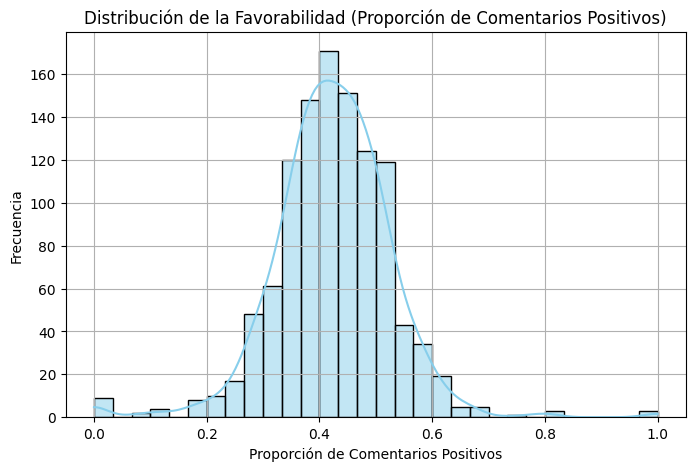

,positive_ratio
count,1105.000000
mean,0.423606
std,0.103801
min,0.000000
25%,0.364964
50%,0.424000
75%,0.485944
max,1.000000


In [ ]:
# Histograma con KDE
plt.figure(figsize=(8, 5))
sns.histplot(df['positive_ratio'], bins=30, kde=True, color='skyblue')
plt.title('Distribución de la Favorabilidad (Proporción de Comentarios Positivos)')
plt.xlabel('Proporción de Comentarios Positivos')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Estadísticas descriptivas
df['positive_ratio'].describe()

---


### 📊 B. Frecuencia por género (`genre`)

* Aquí analizamos cuántas películas hay por género en el dataset.
* Esto nos permite ver cuáles son los tipos de películas más comunes.

Usamos un gráfico de barras, que muestra para cada género cuántos trailers hay.

**Preguntas clave**:
- ¿Qué géneros predominan en la muestra?
- ¿Hay géneros poco representados?


/tmp/ipython-input-82992851.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='genre', order=df['genre'].value_counts().index, palette='pastel')


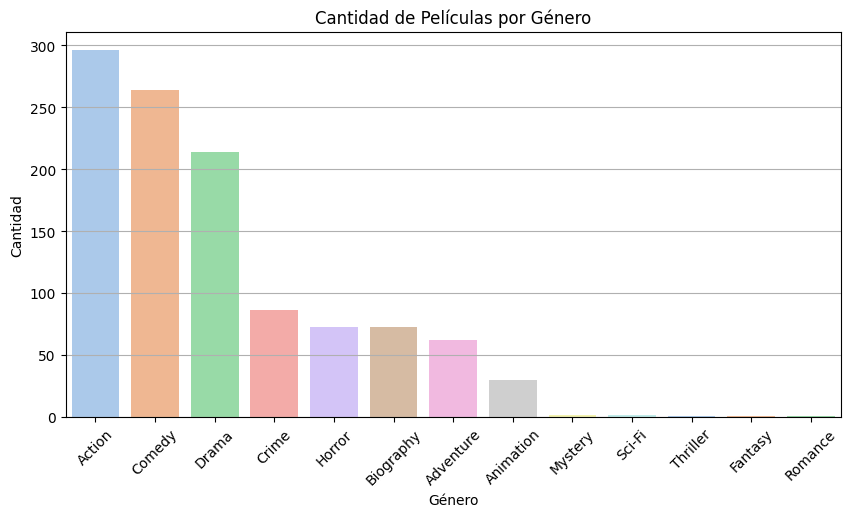

,count
genre,
Action,296
Comedy,264
Drama,214
Crime,86
Horror,73
Biography,73
Adventure,62
Animation,30
Mystery,2


In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='genre', order=df['genre'].value_counts().index, palette='pastel')
plt.title('Cantidad de Películas por Género')
plt.xlabel('Género')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Ver los valores
df['genre'].value_counts()


## 📌 Visualizaciones Bivariadas
---

### 📊 A. Promedio de comentarios positivos por género

Analizamos el promedio de favorabilidad (`positive_ratio`) para cada género.

Esto permite comparar cuáles géneros son mejor recibidos en general.

**¿Qué observamos?**
- Algunos géneros tienen promedios más altos de comentarios positivos.
- Otros tienen una recepción más neutral o baja.
- Comparar la percepción emocional del público según el tipo de película.


/tmp/ipython-input-2058635422.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_mean.index, y=genre_mean.values, palette='pastel')


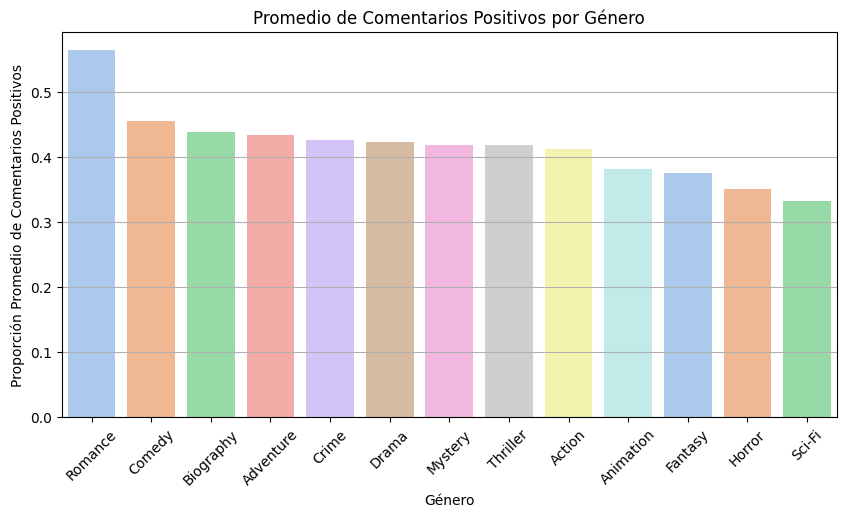

In [ ]:
# Calculamos el promedio de comentarios positivos por género
genre_mean = df.groupby('genre')['positive_ratio'].mean().sort_values(ascending=False)

# Gráfico de barras
plt.figure(figsize=(10, 5))
sns.barplot(x=genre_mean.index, y=genre_mean.values, palette='pastel')
plt.title('Promedio de Comentarios Positivos por Género')
plt.xlabel('Género')
plt.ylabel('Proporción Promedio de Comentarios Positivos')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
